# Scan area detector v. motor

Goals:

- [ ] use EPICS motor(s)
- [ ] use EPICS area detector
  - [ ] For each image
    - [ ] Write image to HDF5 file.
    - [ ] Measure total counts in image.
    - [ ] Measure maximum counts in image.
    - [ ] Note the image's "unique ID".
- [ ] Step scan motor and collect $n$ image frame(s) at each step.
  - [ ] count
  - [ ] scan with one motor
  - [ ] scan with two motors
  - [ ] grid_scan
- [ ] Collect data in a SPEC data file.

## Start the `instrument` package

Our instrument package is in the `bluesky` subdirectory here so we add that to the search path before importing it.

In [1]:
import pathlib, sys

# top = pathlib.Path().resolve().parent.parent.parent
top = pathlib.Path().home()
sys.path.append(str(top / "bluesky"))
from instrument.collection import *

/home/prjemian/bluesky/instrument/_iconfig.py
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/docs/source/howto/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Thu-19:28:12 - ############################################################ startup
I Thu-19:28:12 - logging started
I Thu-19:28:12 - logging level = 10
I Thu-19:28:12 - /home/prjemian/bluesky/instrument/session_logs.py
I Thu-19:28:12 - /home/prjemian/bluesky/instrument/collection.py
I Thu-19:28:12 - CONDA_PREFIX = /home/prjemian/.conda/envs/bluesky_2024_2


Exception reporting mode: Minimal


I Thu-19:28:12 - xmode exception level: 'Minimal'
I Thu-19:28:12 - /home/prjemian/bluesky/instrument/mpl/notebook.py
I Thu-19:28:12 - #### Bluesky Framework ####
I Thu-19:28:12 - /home/prjemian/bluesky/instrument/framework/check_python.py
I Thu-19:28:12 - /home/prjemian/bluesky/instrument/framework/check_bluesky.py
I Thu-19:28:12 - /home/prjemian/bluesky/instrument/framework/initialize.py
I Thu-19:28:12 - RunEngine metadata saved in directory: /home/prjemian/.config/Bluesky_RunEngine_md
I Thu-19:28:12 - using databroker catalog 'training'
I Thu-19:28:12 - using ophyd control layer: pyepics
I Thu-19:28:12 - Using EPICS PV gp:gp:int20 for scan_id
I Thu-19:28:12 - /home/prjemian/bluesky/instrument/framework/metadata.py
I Thu-19:28:12 - #### Devices ####
I Thu-19:28:12 - /home/prjemian/bluesky/instrument/devices/area_detector.py
I Thu-19:28:12 - /home/prjemian/bluesky/instrument/devices/calculation_records.py
I Thu-19:28:15 - /home/prjemian/bluesky/instrument/devices/fourc_diffractometer.p

Make a custom area detector class, providing our own IOC prefix, adding ROI and STATS plugins, and connecting with local directories

In [2]:
from apstools.devices import SingleTrigger_V34
from instrument.devices.area_detector import MyHDF5Plugin
from instrument.devices.area_detector import SimDetectorCam_V34
from ophyd.areadetector import ADComponent
from ophyd.areadetector import DetectorBase
from ophyd.areadetector.plugins import ImagePlugin_V34
from ophyd.areadetector.plugins import PvaPlugin_V34
from ophyd.areadetector.plugins import ROIPlugin_V34
from ophyd.areadetector.plugins import StatsPlugin_V34
import hdf5plugin  # TODO: explain why this was needed.

FILE_BASE_IOC = "/tmp/"
FILE_BASE_BLUESKY = "/mnt/iockad/tmp/"

class SimDetector_V34(SingleTrigger_V34, DetectorBase):
    """
    ADSimDetector

    SingleTrigger:

    * stop any current acquisition
    * sets image_mode to 'Multiple'
    """

    cam = ADComponent(SimDetectorCam_V34, "cam1:")
    hdf1 = ADComponent(
        MyHDF5Plugin,
        "HDF1:",
        write_path_template=FILE_BASE_IOC,
        read_path_template=FILE_BASE_BLUESKY,
    )
    image = ADComponent(ImagePlugin_V34, "image1:")
    pva = ADComponent(PvaPlugin_V34, "Pva1:")
    roi1 = ADComponent(ROIPlugin_V34, "ROI1:")
    stats1 = ADComponent(StatsPlugin_V34, "Stats1:")

simdet = SimDetector_V34("kad:", name="simdet")

## Setup & connect with EPICS

Search the ophyd object registry (`oregistry`) for the detector and motors. Show that each is connected to EPICS.

In [3]:
for nm in "simdet m1 m2".split():
    obj = oregistry.find(nm)
    print(f"{obj.connected=!r} {nm!r}")

obj.connected=True 'simdet'
obj.connected=True 'm1'
obj.connected=True 'm2'


Configure the area detector for:

- Collect $n$ image frame(s) for each press of the *Acquire* button.
- Save image(s) to HDF5
- Record total counts in the image.
- Record maximum counts in the image.
- Record the unique ID of the image.

In [4]:
def ad_setup(det):
    det.wait_for_connection(timeout=3)
    det.roi1.nd_array_port.put("SIM1")
    det.stats1.nd_array_port.put("ROI1")
    det.missing_plugins()

    det.cam.stage_sigs["num_images"] = 3

    det.hdf1.kind = "hinted"
    det.hdf1.create_directory.put(-5)
    det.hdf1.stage_sigs["compression"] = "LZ4"

    det.stats1.kind = "hinted"
    det.stats1.max_value.kind = "hinted"
    det.stats1.total.kind = "hinted"
    det.stats1.unique_id.kind = "hinted"

    det.cam.stage_sigs["wait_for_plugins"] = "Yes"
    det.hdf1.stage_sigs["blocking_callbacks"] = "No"
    det.image.stage_sigs["blocking_callbacks"] = "No"

ad_setup(simdet)

## Diagnostics (optional)

These steps are optional.

Show the data structure collected by the `RE` during a routine data acquisition
run with the area detector object `simdet`.

In [5]:
simdet.read()

OrderedDict([('simdet_stats1_unique_id',
              {'value': 1760, 'timestamp': 1718324778.672825}),
             ('simdet_stats1_max_value',
              {'value': 161.0, 'timestamp': 1718324899.705706}),
             ('simdet_stats1_total',
              {'value': 11530507.0, 'timestamp': 1718324899.7284331})])

Show how `simdet` is configured to collect $n$ frames per point.

In [6]:
print("Image frames per point:", simdet.cam.stage_sigs["num_images"])

Image frames per point: 3


Show the staging configuration for `simdet`.

In [7]:
from pprint import pprint

pprint({"simdet": simdet.stage_sigs})
pprint({"simdet.cam": simdet.cam.stage_sigs})
pprint({"simdet.hdf1": simdet.hdf1.stage_sigs})
pprint({"simdet.roi1": simdet.roi1.stage_sigs})
pprint({"simdet.stats1": simdet.stats1.stage_sigs})

{'simdet': OrderedDict([('cam.acquire', 0), ('cam.image_mode', 1)])}
{'simdet.cam': OrderedDict([('num_images', 3), ('wait_for_plugins', 'Yes')])}
{'simdet.hdf1': OrderedDict([('enable', 1),
                             ('blocking_callbacks', 'No'),
                             ('parent.cam.array_callbacks', 1),
                             ('create_directory', -3),
                             ('auto_increment', 'Yes'),
                             ('array_counter', 0),
                             ('auto_save', 'Yes'),
                             ('num_capture', 0),
                             ('file_template', '%s%s_%6.6d.h5'),
                             ('file_write_mode', 'Stream'),
                             ('capture', 1),
                             ('compression', 'LZ4')])}
{'simdet.roi1': OrderedDict([('enable', 1),
                             ('blocking_callbacks', 'Yes'),
                             ('parent.cam.array_callbacks', 1)])}
{'simdet.stats1': OrderedDict

Show how the area detector ports are connected in a diagram.

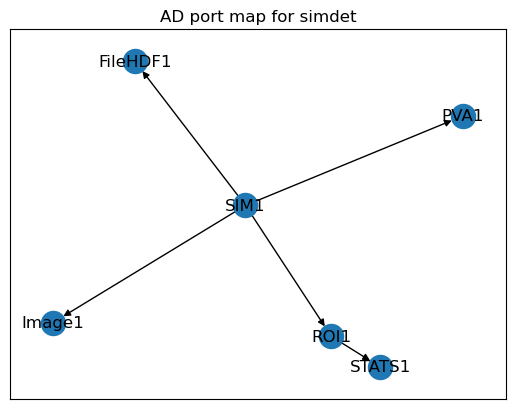

In [8]:
simdet.visualize_asyn_digraph()

Just read the signals from `simdet.stats1` multiple times.  Since `simdet` itself is not included in the list of detectors, it will not be triggered (and thus will not produce new images).  Observe that the `unique_id` does not change.  For clarity, the command has been split into multiple lines.



Transient Scan ID: 47     Time: 2024-06-13 19:28:20
Persistent Unique Scan ID: '67ad927f-a3ce-4aaa-9cc2-a9c6c017751e'


device=MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']), exception=Data keys (field names) from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']) collide with those from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']). The colliding keys are {'m2', 'm2_user_setpoint'}


New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+-------------------------+---------------------+-------------------------+
|   seq_num |       time | simdet_stats1_max_value | simdet_stats1_total | simdet_stats1_unique_id |
+-----------+------------+-------------------------+---------------------+-------------------------+
|         1 | 19:28:21.0 |                     161 |            11530507 |                    1760 |
|         2 | 19:28:21.4 |                     161 |            11530507 |                    1760 |
|         3 | 19:28:21.8 |                     161 |            11530507 |                    1760 |
|         4 | 19:28:22.1 |                     161 |            11530507 |                    1760 |
|         5 | 19:28:22.5 |                     161 |            11530507 |                    1760 |
+-----------+------------+-------------------------+---------------------+-------------------------+
generator count ['67ad927f'] (scan nu

('67ad927f-a3ce-4aaa-9cc2-a9c6c017751e',)

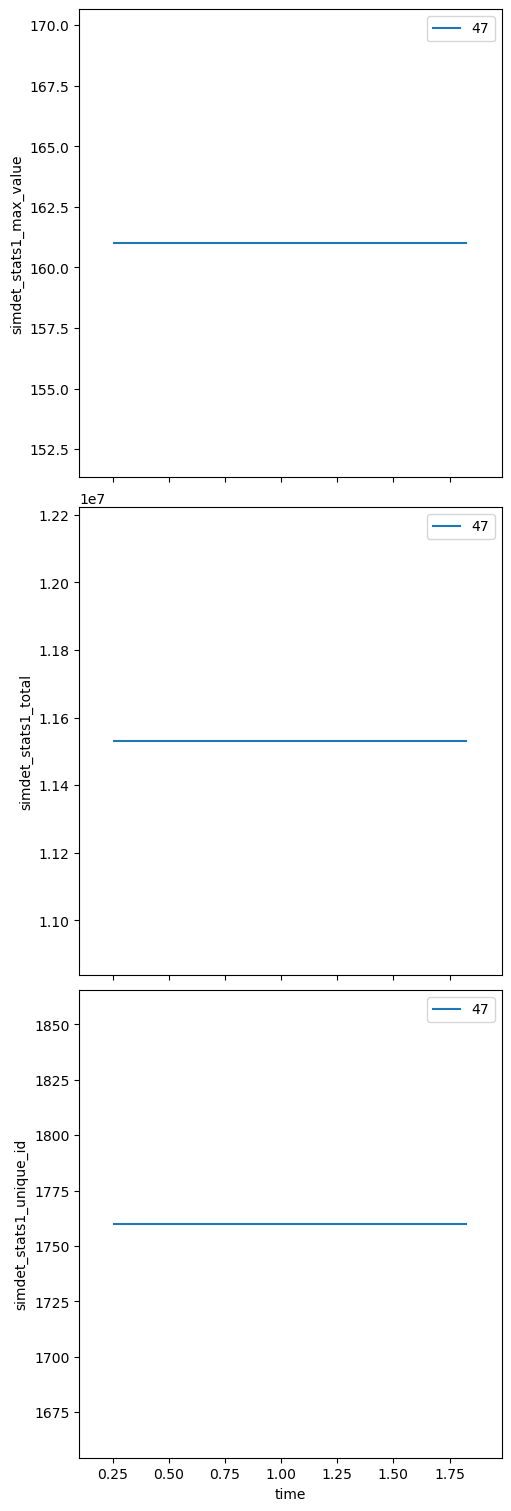

In [9]:
RE(
    bp.count(
        [
            simdet.stats1.unique_id, 
            simdet.stats1.total, 
            simdet.stats1.max_value
            ], 
        num=5
        )
    )

In [10]:
run = cat[-1]  # assume our run is the most recent one in the catalog
print(f"{run=!r}")
dataset = run.primary.read()
dataset

run=<BlueskyRun uid='67ad927f-a3ce-4aaa-9cc2-a9c6c017751e'>


/home/prjemian/.conda/envs/bluesky_2024_2/lib/python3.11/site-packages/databroker/intake_xarray_core/base.py:23: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 160B
Dimensions:                  (time: 5)
Coordinates:
  * time                     (time) float64 40B 1.718e+09 ... 1.718e+09
Data variables:
    simdet_stats1_max_value  (time) float64 40B 161.0 161.0 161.0 161.0 161.0
    simdet_stats1_total      (time) float64 40B 1.153e+07 ... 1.153e+07
    simdet_stats1_unique_id  (time) int64 40B 1760 1760 1760 1760 1760

## The `bp.count()` plan

Collect 5 sets of images (3-frames each as configured above).



Transient Scan ID: 48     Time: 2024-06-13 19:28:24
Persistent Unique Scan ID: 'b4f7085d-5ea4-4a85-92a2-d79604d800c4'


device=MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']), exception=Data keys (field names) from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']) collide with those from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']). The colliding keys are {'m2', 'm2_user_setpoint'}


New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+-------------------------+-------------------------+---------------------+
|   seq_num |       time | simdet_stats1_unique_id | simdet_stats1_max_value | simdet_stats1_total |
+-----------+------------+-------------------------+-------------------------+---------------------+
|         1 | 19:28:24.6 |                    1763 |                     163 |            11657581 |
|         2 | 19:28:25.1 |                    1766 |                     162 |            11534722 |
|         3 | 19:28:25.5 |                    1769 |                     165 |            11771089 |
|         4 | 19:28:25.9 |                    1772 |                     166 |            11821774 |
|         5 | 19:28:26.3 |                    1775 |                     161 |            11454627 |
+-----------+------------+-------------------------+-------------------------+---------------------+
generator count ['b4f7085d'] (scan nu

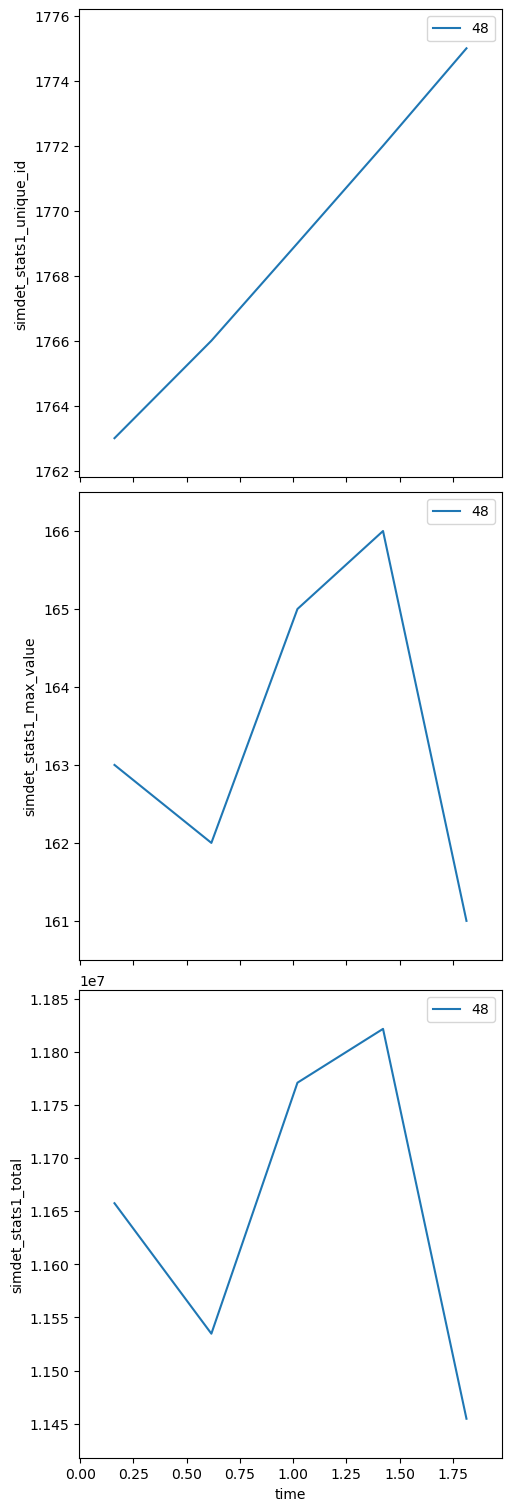

In [11]:
uids = RE(bp.count([simdet], num=5))
print(f"uids=!r")

Drill into the data for the run from the catalog.

Show the first image frame from the first *point*.

image_data.shape=(5, 3, 1024, 1024)


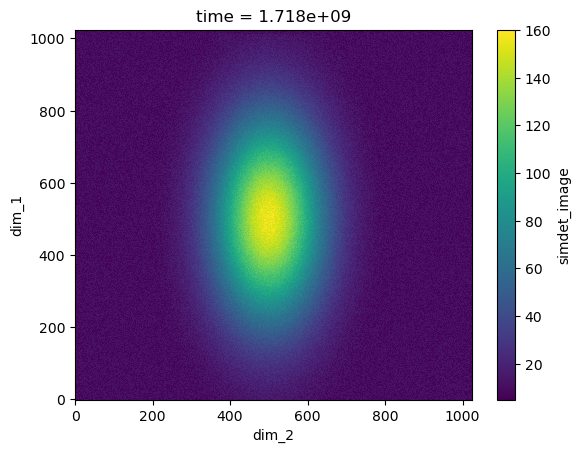

In [12]:
image_data = cat[uids[-1]].primary.read()["simdet_image"]
print(f"{image_data.shape=!r}")
image_data[0][0].plot.pcolormesh()  # Plot the first frame.

Information about the HDF5 file is saved as a `resource` document in the catalog.  This command shows the content of that document.

In [13]:
run = cat[uids[-1]]
resources = run.primary._resources
resources

[Resource({'path_semantics': 'posix',
 'resource_kwargs': {'frame_per_point': 3},
 'resource_path': 'mnt/iockad/tmp/91b58eee-ea30-41b5-97eb_000000.h5',
 'root': '/',
 'run_start': 'b4f7085d-5ea4-4a85-92a2-d79604d800c4',
 'spec': 'AD_HDF5',
 'uid': '790568ad-33a3-4472-bbd1-8add9e2812bd'})]

Note this is a Python `list`.
The file name, as the catalog will find its image contents, is reconstructed:

In [14]:
resources[0]["root"] + resources[0]["resource_path"]

'/mnt/iockad/tmp/91b58eee-ea30-41b5-97eb_000000.h5'

Show that this file is recognized on the file system available to Bluesky.

In [15]:
from pathlib import Path
image_file = Path(resources[0]["root"] + resources[0]["resource_path"])
image_file.exists()

True

## The (1-D) `bp.scan()` plan with one motor

Step scan a motor (m1) and measure 3 (as configured above) images at each step.  Also record total counts and the maximum counts value for each step.



Transient Scan ID: 49     Time: 2024-06-13 19:28:29
Persistent Unique Scan ID: '6a685a7b-78a0-4005-b701-321644b426fb'


device=MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']), exception=Data keys (field names) from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']) collide with those from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']). The colliding keys are {'m2', 'm2_user_setpoint'}


New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+------------+-------------------------+-------------------------+---------------------+
|   seq_num |       time |         m1 | simdet_stats1_unique_id | simdet_stats1_max_value | simdet_stats1_total |
+-----------+------------+------------+-------------------------+-------------------------+---------------------+
|         1 | 19:28:31.4 |    -1.0000 |                    1778 |                     159 |            11376209 |
|         2 | 19:28:32.7 |    -0.5000 |                    1781 |                     165 |            11789767 |
|         3 | 19:28:33.9 |     0.0000 |                    1784 |                     160 |            11396108 |
|         4 | 19:28:35.1 |     0.5000 |                    1787 |                     163 |            11658001 |
|         5 | 19:28:36.3 |     1.0000 |                    1790 |                     159 |            11366771 |
+-----------+------------+--------

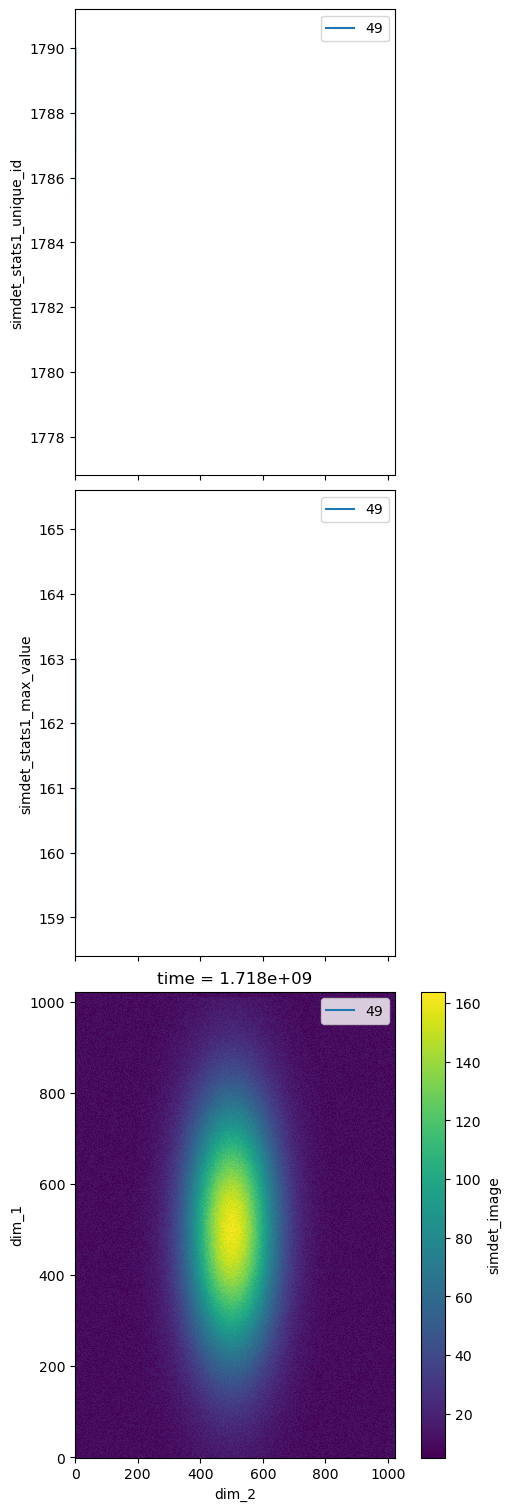

In [16]:
uids = RE(bp.scan([simdet], m1, -1, 1, 5))
print(f"uids=!r")
image_data = cat[uids[-1]].primary.read()["simdet_image"]
print(f"{image_data.shape=!r}")
image_data[0][0].plot.pcolormesh() # Plot the first frame.

## The (1-D) `bp.scan()` plan with two motors

Step scan two motors together (m1 & m2) and measure 3 (as configured above) images at each step.  Also record total counts and the maximum counts value for each step.

For clarity, the `scan` arguments are split into multiple lines.



Transient Scan ID: 50     Time: 2024-06-13 19:28:41
Persistent Unique Scan ID: '8ec566e6-f2e8-4b3e-9840-5373428d2f6f'


device=MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']), exception=Data keys (field names) from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']) collide with those from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']). The colliding keys are {'m2', 'm2_user_setpoint'}


New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+------------+------------+-------------------------+-------------------------+---------------------+
|   seq_num |       time |         m1 |         m2 | simdet_stats1_unique_id | simdet_stats1_max_value | simdet_stats1_total |
+-----------+------------+------------+------------+-------------------------+-------------------------+---------------------+
|         1 | 19:28:45.3 |    -1.0000 |     4.0000 |                    1793 |                     161 |            11464113 |
|         2 | 19:28:46.6 |    -0.5000 |     3.3750 |                    1796 |                     161 |            11465357 |
|         3 | 19:28:47.9 |     0.0000 |     2.7500 |                    1799 |                     161 |            11517247 |
|         4 | 19:28:49.2 |     0.5000 |     2.1250 |                    1802 |                     160 |            11363070 |
|         5 | 19:28:50.5 |     1.0000 |     1.5000 |     

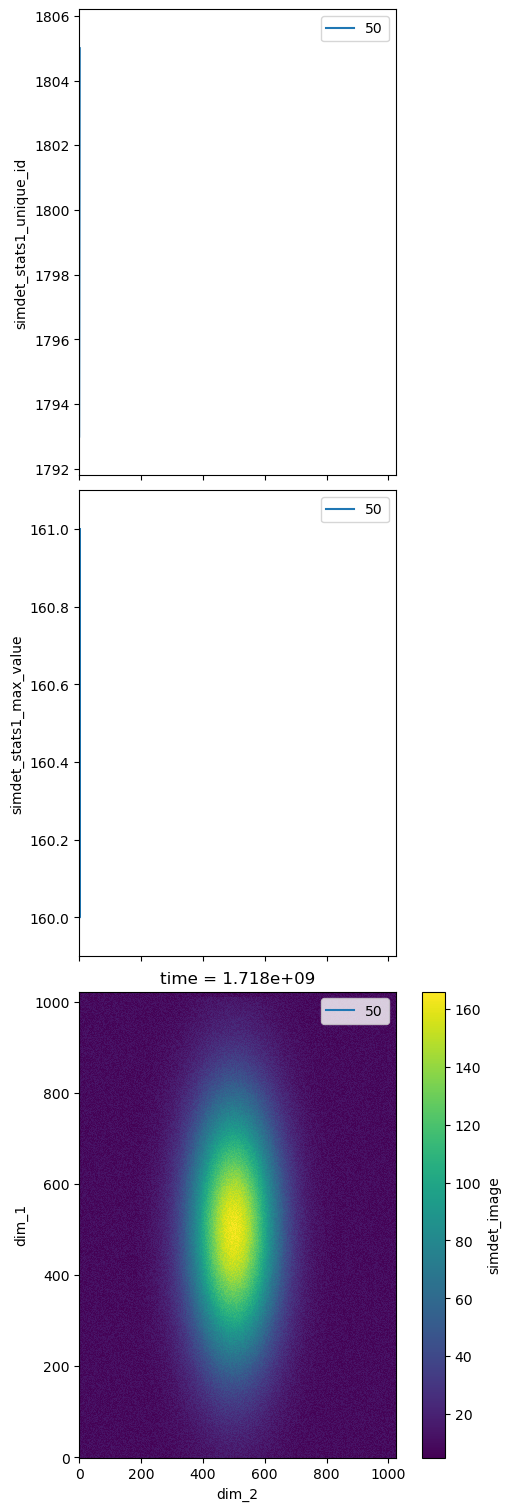

In [17]:
uids = RE(
    bp.scan(
        [simdet],
        m1, -1, 1,
        m2, 4, 1.5,
        5,
    )
)
print(f"uids=!r")
image_data = cat[uids[-1]].primary.read()["simdet_image"]
print(f"{image_data.shape=!r}")
image_data[0][0].plot.pcolormesh() # Plot the first frame.

## The (2-D) `bp.grid_scan()` (mesh) plan

Step scan two motors (m1 & m2) and measure images at each step, as before.  Also record total counts and the maximum counts value for each step.

For clarity, the `grid_scan` arguments are split into multiple lines.



Transient Scan ID: 51     Time: 2024-06-13 19:28:55
Persistent Unique Scan ID: 'f5789eec-51d2-4b85-ac2b-87bcd415f991'


device=MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']), exception=Data keys (field names) from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']) collide with those from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']). The colliding keys are {'m2', 'm2_user_setpoint'}


New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+------------+------------+-------------------------+-------------------------+---------------------+
|   seq_num |       time |         m1 |         m2 | simdet_stats1_unique_id | simdet_stats1_max_value | simdet_stats1_total |
+-----------+------------+------------+------------+-------------------------+-------------------------+---------------------+
|         1 | 19:28:57.9 |    -1.0000 |    -0.5000 |                    1808 |                     160 |            11426845 |
|         2 | 19:28:59.3 |    -1.0000 |    -0.1667 |                    1811 |                     166 |            11821200 |
|         3 | 19:29:00.6 |    -1.0000 |     0.1667 |                    1814 |                     163 |            11658226 |
|         4 | 19:29:01.9 |    -1.0000 |     0.5000 |                    1817 |                     164 |            11725745 |
|         5 | 19:29:03.4 |    -0.5000 |     0.5000 |     

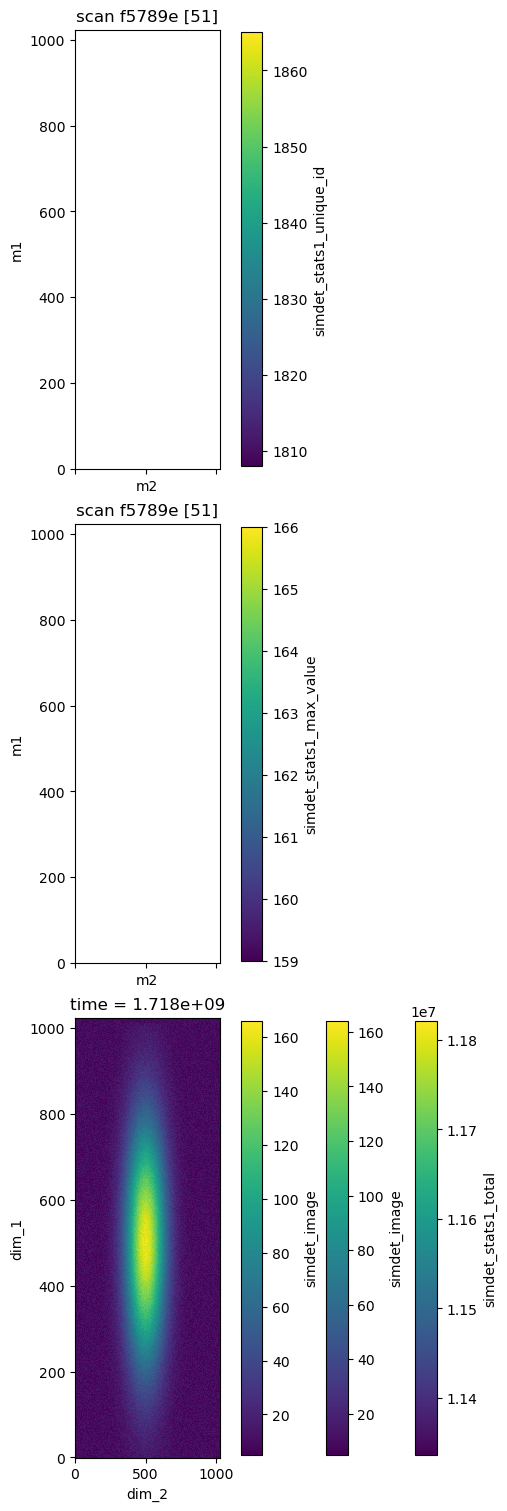

In [18]:
uids = RE(
    bp.grid_scan(
        [simdet], 
        m1, -1, 1, 5,
        m2, -0.5, 0.5, 4,
        snake_axes=True,
    )
)
print(f"uids=!r")
image_data = cat[uids[-1]].primary.read()["simdet_image"]
print(f"{image_data.shape=!r}")
image_data[0][0].plot.pcolormesh() # Plot the first frame of the first point.
image_data[-1][0].plot.pcolormesh() # Plot the first frame of the last point.

## SPEC data file

All along, quitely in the background, the data has been saved both to a catalog
and to a SPEC data file.  Show the SPEC file.  The total counts, max counts, and
unique ID from all scans can be plotted from the SPEC file using PyMCA or NeXpy.
The image content is not stored in the SPEC file; images cannot be viewed from
the SPEC file.  However, references to the images are save as comments.  See
comment lines that match a search for `resource {'spec': 'AD_HDF5'`, such as
this one:

```
#C Thu Jun 13 11:36:38 2024.  resource {'spec': 'AD_HDF5', 'root': '/', 'resource_path': 'mnt/iockad/tmp/d94f633b-12a7-4ff0-92af_000000.h5', 'resource_kwargs': {'frame_per_point': 3}, 'path_semantics': 'posix', 'uid': '5328206b-dd13-49f8-b108-17e0d867d470', 'run_start': 'e8c24278-656f-4c79-b3eb-d522310f7649'}
```

In [19]:
# from instrument.callbacks.spec_data_file_writer import specwriter

print(f"{specwriter.spec_filename=!r}\n")
with open(specwriter.spec_filename) as f:
    print(f.read())

specwriter.spec_filename=PosixPath('/home/prjemian/Documents/projects/BCDA-APS/bluesky_training/docs/source/howto/20240613-192819.dat')

#F /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/docs/source/howto/20240613-192819.dat
#E 1718324899
#D Thu Jun 13 19:28:19 2024
#C Bluesky  user = prjemian  host = arf.jemian.org
#O0 dcm_m_theta  dcm_m_y  dcm_m_z  fourc_chi  fourc_omega  fourc_phi  fourc_tth  m1
#O1 m10  m11  m12  m13  m14  m15  m16  m2
#O2 m3  m4  m7  m8  m9  sixc_chi  sixc_delta  sixc_gamma
#O3 sixc_mu  sixc_omega  sixc_phi
#o0 dcm_m_theta  dcm_m_y  dcm_m_z  fourc_chi  fourc_omega  fourc_phi  fourc_tth  m1
#o1 m10  m11  m12  m13  m14  m15  m16  m2
#o2 m3  m4  m7  m8  m9  sixc_chi  sixc_delta  sixc_gamma
#o3 sixc_mu  sixc_omega  sixc_phi

#S 47  count(detectors=['simdet_stats1_unique_id', 'simdet_stats1_total', 'simdet_stats1_max_value'], num=5, delay=None)
#D Thu Jun 13 19:28:20 2024
#C Thu Jun 13 19:28:20 2024.  plan_type = generator
#C Thu Jun 13 19:28:20 2024.  uid